In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Dataset

In [27]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-09-18 19:31:10--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.2’

housing.csv.2       100%[===================>]   1.36M  3.09MB/s    in 0.4s    

2023-09-18 19:31:11 (3.09 MB/s) - ‘housing.csv.2’ saved [1423529/1423529]



In [28]:
df = pd.read_csv('housing.csv')

df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### Long tail of median_house_value

<Axes: xlabel='median_house_value', ylabel='Count'>

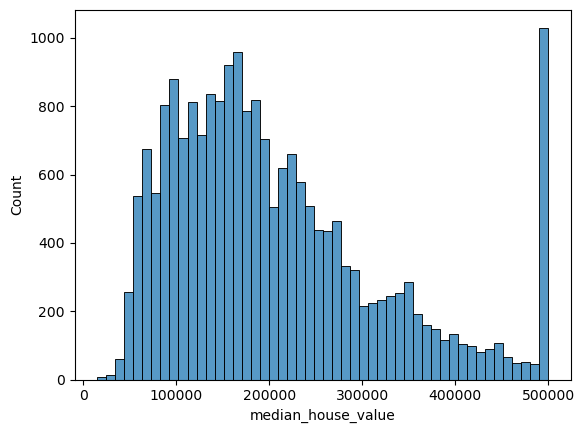

In [29]:
# long tail distribution 
sns.histplot(df.median_house_value, bins=50)

<Axes: xlabel='median_house_value', ylabel='Count'>

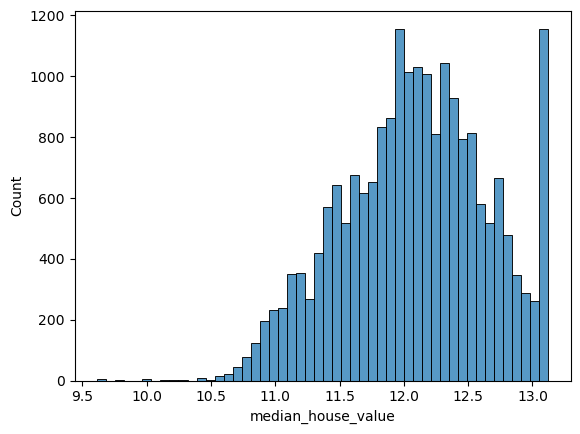

In [30]:
sns.histplot(np.log1p(df.median_house_value), bins=50)

### Preparing the dataset

In [31]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])][['latitude','longitude',
                                                              'housing_median_age','total_rooms',
                                                              'total_bedrooms','population',
                                                              'households',
                                                              'median_income','median_house_value']]

# Question 1: total_bedrooms
There's one feature with missing values. What is it?

In [32]:
df.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

# Question 2: 1195
What's the median (50% percentile) for variable 'population'?

In [33]:
np.median(df.population)

1195.0

# Prepare and split the dataset
* Shuffle the initial dataset, use seed 42.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [34]:
np.random.seed(42)

n = len(df)

n_val = int(n * 0.2) #20%
n_test = int(n * 0.2) #20%
n_train = n - n_val - n_test # remaining 60%

n, n_val, n_test, n_train

idx = np.arange(n) 

np.random.shuffle(idx)

In [35]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [36]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [37]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

# Question 3: mean gives a better (smaller) RMSE
We need to deal with missing values for the column from Q1.

We have two options: fill it with 0 or with the mean of this variable.

Try both options. For each, train a linear regression model without regularization using the code from the lessons.

For computing the mean, use the training only!

Use the validation dataset to evaluate the models and compare the RMSE of each option.

Round the RMSE scores to 2 decimal digits using round(score, 2)

Which option gives better RMSE?

Options:

* With 0
* With mean
* Both are equally good


In [38]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def prepare_X_fillna0(df, base):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def prepare_X_fillna_mean(df, base):
    df_num = df[base]
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values
    return X

### fill with 0

In [45]:
base = ['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

In [46]:
X_train = prepare_X_fillna0(df_train, base)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_fillna0(df_val, base)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.3408479034201643

### fill with mean

In [47]:
X_train = prepare_X_fillna_mean(df_train, base)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_fillna_mean(df_val, base)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.3405701119717301

# Question 4, reg alpha is 0
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?
* If there are multiple options, select the smallest r.

In [49]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    # add reg param to the diagonal before inverting to find weights 
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    # inversion 
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [50]:
base = ['latitude', 'longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X_fillna0(df_train, base)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X_fillna0(df_val, base)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, np.round(score, 2))

0 -9.76324947792922 0.34
1e-06 -9.76322883158197 0.34
0.0001 -9.761185235939118 0.34
0.001 -9.74264624988528 0.34
0.01 -9.561056193156471 0.34
0.1 -8.058889769818059 0.34
1 -3.1331542785822872 0.34
5 -0.8410867975333891 0.35
10 -0.4381172315908744 0.35


# Question 5, 0.005
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

In [57]:
rmse_list = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
    np.random.seed(seed)
    
    n = len(df)

    n_val = int(n * 0.2) #20%
    n_test = int(n * 0.2) #20%
    n_train = n - n_val - n_test # remaining 60%
    idx = np.arange(n) 
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_train = prepare_X_fillna0(df_train, base)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X_fillna0(df_val, base)
    y_pred = w0 + X_val.dot(w)
    
    print ('seed is:%s, rmse is:%s' % (seed, rmse(y_val, y_pred)))
    
    rmse_list.append(rmse(y_val, y_pred))
    
print ()
print ('rmse std is %s' % np.round(np.std(np.array(rmse_list)), 3))

seed is:0, rmse is:0.33773871601241534
seed is:1, rmse is:0.33779993536620034
seed is:2, rmse is:0.3384287006770243
seed is:3, rmse is:0.3320049468307805
seed is:4, rmse is:0.3394451862556948
seed is:5, rmse is:0.3433819705265852
seed is:6, rmse is:0.3385330211770784
seed is:7, rmse is:0.34687476973049747
seed is:8, rmse is:0.35127368659561153
seed is:9, rmse is:0.3341558266517612

rmse std is 0.005


# Question 6, 0.33
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.
* What's the RMSE on the test dataset?

In [58]:
np.random.seed(9)


n = len(df)

n_val = int(n * 0.2) #20%
n_test = int(n * 0.2) #20%
n_train = n - n_val - n_test # remaining 60%
idx = np.arange(n) 
np.random.shuffle(idx)
    
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]
    
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)
    
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [61]:
# combine train and validation 

df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

X_full_train = prepare_X_fillna0(df_full_train, base)
y_full_train = np.concatenate([y_train, y_val])

In [62]:
# Fill the missing values with 0 and train a model with r=0.001.

w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [65]:
# RMSE on test 

X_test = prepare_X_fillna0(df_test, base)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

0.3349899336608947